In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer
import scipy.stats as stats
import matplotlib.pyplot as plt
# Read data
df = pd.read_csv("water_potability_1.csv")

## Features Extraction

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          2785 non-null   float64
 1   Solids      3276 non-null   float64
 2   Turbidity   3276 non-null   float64
 3   Potability  3276 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 102.5 KB


In [3]:
df.isnull().sum()

ph            491
Solids          0
Turbidity       0
Potability      0
dtype: int64

def impute_na(df, variable):
    # function to fill na with a random sample
    data = df.copy()
    
    # random sampling
    data[variable+'_random'] = data[variable]
    
    # extract the random sample to fill the na
    random_sample = data[variable].dropna().sample(data[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = data[data[variable].isnull()].index
    data.loc[data[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [4]:
df['ph'] = df['ph'].fillna(value=df['ph'].median())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ph          3276 non-null   float64
 1   Solids      3276 non-null   float64
 2   Turbidity   3276 non-null   float64
 3   Potability  3276 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 102.5 KB


df['ph']=impute_na(df,'ph')

In [5]:
df.head()

,ph,Solids,Turbidity,Potability
0,7.036752,20791.31898,2.963135,0
1,3.716080,18630.05786,4.500656,0
2,8.099124,19909.54173,3.055934,0
3,8.316766,22018.41744,4.628771,0
4,9.092223,17978.98634,4.075075,0


df['Acidic'] = df['ph'].apply(lambda x: '1' if x<=7 else '0')
df['Alkaline'] = df['ph'].apply(lambda x: '1' if x>7 else '0')

In [6]:
df.head()

,ph,Solids,Turbidity,Potability
0,7.036752,20791.31898,2.963135,0
1,3.716080,18630.05786,4.500656,0
2,8.099124,19909.54173,3.055934,0
3,8.316766,22018.41744,4.628771,0
4,9.092223,17978.98634,4.075075,0


In [7]:
df['ph.'] = df['ph'].apply(lambda x:x//1)
df['.ph'] = df['ph'].apply(lambda x:x%1)
df['Solids.'] = df['Solids'].apply(lambda x:x//1)
df['.Solids'] = df['Solids'].apply(lambda x:x%1)
df['Turbidity.'] = df['Turbidity'].apply(lambda x:x//1)
df['.Turbidity'] = df['Turbidity'].apply(lambda x:x%1)

df.head()

,ph,Solids,Turbidity,Potability,ph.,.ph,Solids.,.Solids,Turbidity.,.Turbidity
0,7.036752,20791.31898,2.963135,0,7.0,0.036752,20791.0,0.31898,2.0,0.963135
1,3.716080,18630.05786,4.500656,0,3.0,0.716080,18630.0,0.05786,4.0,0.500656
2,8.099124,19909.54173,3.055934,0,8.0,0.099124,19909.0,0.54173,3.0,0.055934
3,8.316766,22018.41744,4.628771,0,8.0,0.316766,22018.0,0.41744,4.0,0.628771
4,9.092223,17978.98634,4.075075,0,9.0,0.092223,17978.0,0.98634,4.0,0.075075


In [8]:
df = df[['ph', 'Solids', 'Turbidity','ph.','.ph','Solids.','.Solids','Turbidity.','.Turbidity','Potability']]
df.head()

,ph,Solids,Turbidity,ph.,.ph,Solids.,.Solids,Turbidity.,.Turbidity,Potability
0,7.036752,20791.31898,2.963135,7.0,0.036752,20791.0,0.31898,2.0,0.963135,0
1,3.716080,18630.05786,4.500656,3.0,0.716080,18630.0,0.05786,4.0,0.500656,0
2,8.099124,19909.54173,3.055934,8.0,0.099124,19909.0,0.54173,3.0,0.055934,0
3,8.316766,22018.41744,4.628771,8.0,0.316766,22018.0,0.41744,4.0,0.628771,0
4,9.092223,17978.98634,4.075075,9.0,0.092223,17978.0,0.98634,4.0,0.075075,0


In [9]:
df = df.drop(['ph', 'Solids','Turbidity'], axis=1)

In [10]:
df.head()

,ph.,.ph,Solids.,.Solids,Turbidity.,.Turbidity,Potability
0,7.0,0.036752,20791.0,0.31898,2.0,0.963135,0
1,3.0,0.716080,18630.0,0.05786,4.0,0.500656,0
2,8.0,0.099124,19909.0,0.54173,3.0,0.055934,0
3,8.0,0.316766,22018.0,0.41744,4.0,0.628771,0
4,9.0,0.092223,17978.0,0.98634,4.0,0.075075,0


In [11]:
def diagnostic_plots(data, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    data[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(data[variable], dist="norm", plot=plt)

    plt.show()

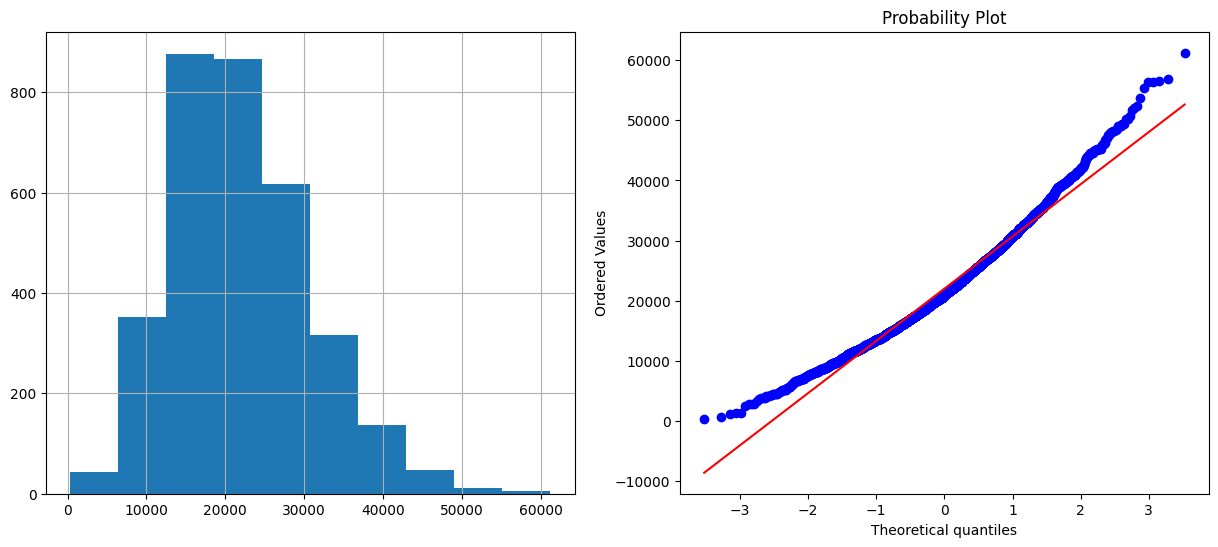

In [12]:
diagnostic_plots(df, 'Solids.')

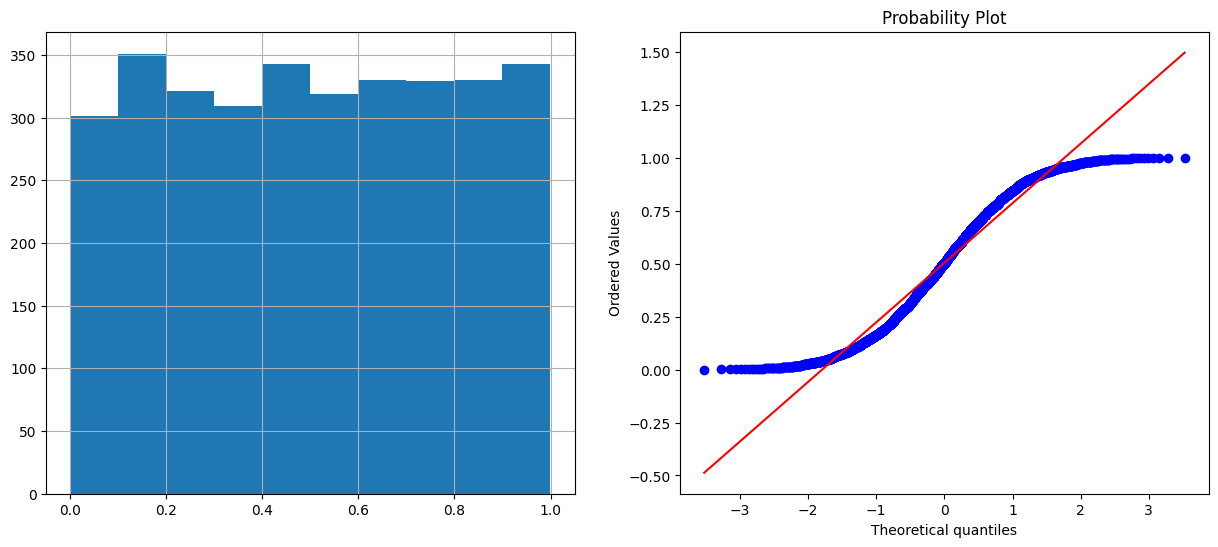

In [13]:
diagnostic_plots(df, '.Turbidity')

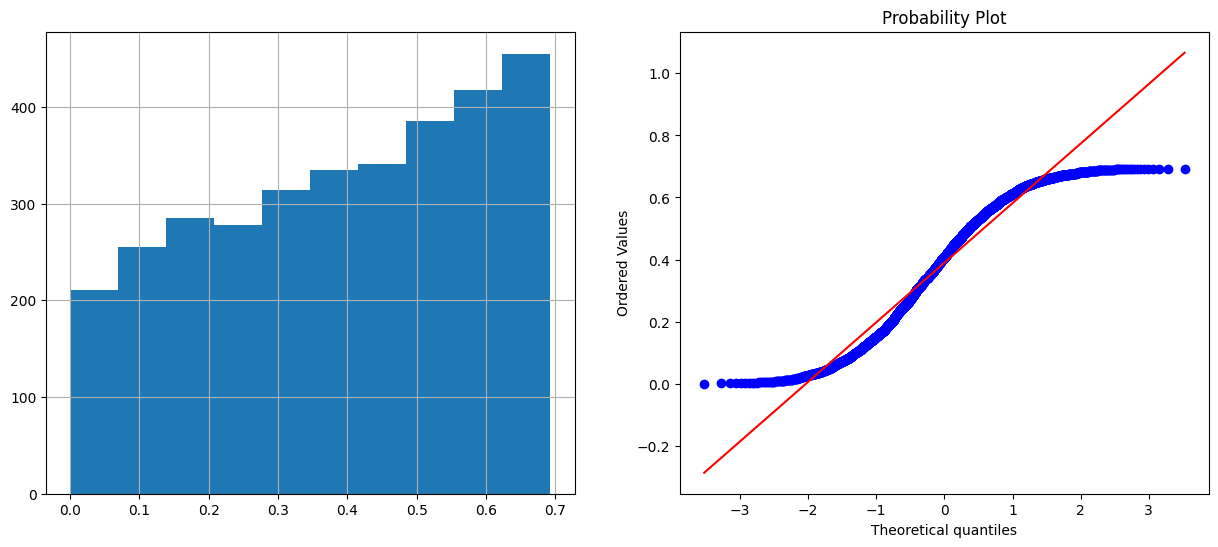

In [133]:
df['Log_.Turbidity']=np.log(df['.Turbidity']+1)
diagnostic_plots(df,'Log_.Turbidity')

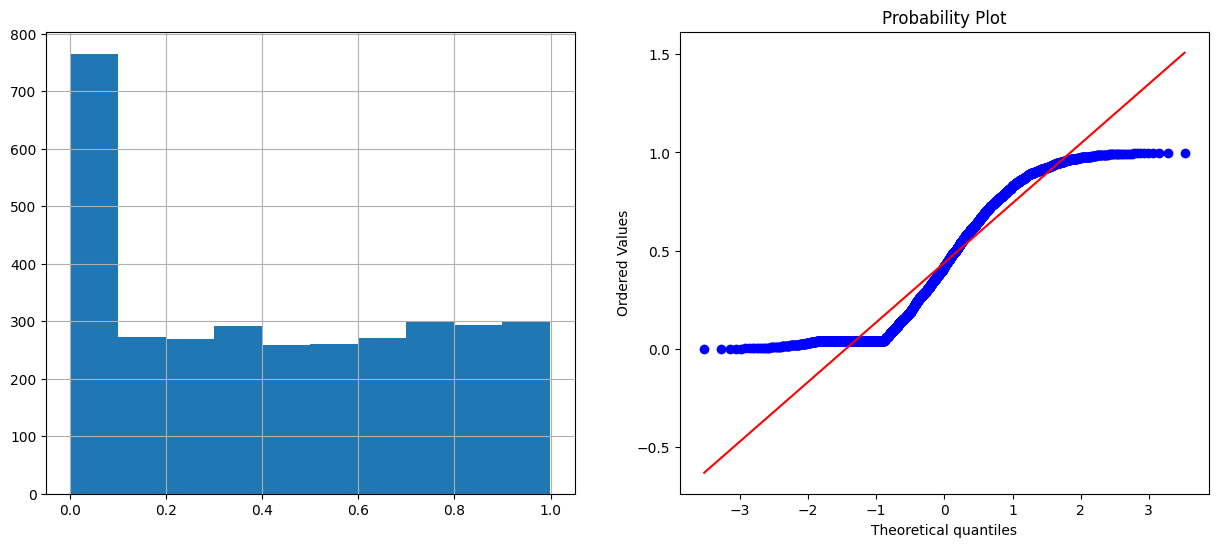

In [55]:
diagnostic_plots(df, '.ph')

In [18]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
df.values[:,:-1],
df.values[:,-1:],
test_size=0.4,
random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (1965, 6) (1965,)
Testing dataset shape: (1311, 6) (1311,)


## Random Forest

In [19]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [20]:
# Build step forward feature selection
sfs1 = sfs(clf,
k_features=5, 
forward=True, 
floating=False, 
verbose=2,
scoring='accuracy',
cv=0)


In [21]:
# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.1s finished

[2023-03-28 21:10:44] Features: 1/5 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished

[2023-03-28 21:10:45] Features: 2/5 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished

[2023-03-28 21:10:45] Features: 3/5 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

In [22]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 5]


In [23]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=150, max_depth=7)
clf.fit(X_train[:, feat_cols], y_train)

RandomForestClassifier(max_depth=7, n_estimators=1000, random_state=150)

In [24]:
y_train_pred = clf.predict(X_train[:, feat_cols])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
y_test_pred = clf.predict(X_test[:, feat_cols])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on selected features: 0.695
Testing accuracy on selected features: 0.622


In [25]:
# Build full model on ALL features, for comparison
clf = RandomForestClassifier(n_estimators=1000, random_state=150, max_depth=7)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
print('Training accuracy on all features: %.3f' % acc(y_train, y_train_pred))
y_test_pred = clf.predict(X_test)
print('Testing accuracy on all features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on all features: 0.685
Testing accuracy on all features: 0.617


### Boosting - Ada Boost

In [26]:

adb1 = AdaBoostClassifier(RandomForestClassifier(),n_estimators = 5, learning_rate = 1) #implement AdaBoost on 5 decision tree 
adb1.fit(X_train,y_train) #fit into train dataset

AdaBoostClassifier(estimator=RandomForestClassifier(), learning_rate=1,
                   n_estimators=5)

In [27]:
#Boosting accuracy for test dataset
adb1.score(X_test,y_test)

0.5903890160183066

### Bagging

In [32]:
bg1 = BaggingClassifier(RandomForestClassifier(), max_samples= 0.5, max_features = 1.0, n_estimators = 20) #each bag contains 50% samples of training data, all features used and 20 decision tree
bg1.fit(X_train,y_train) #fit into train dataset

BaggingClassifier(estimator=RandomForestClassifier(), max_samples=0.5,
                  n_estimators=20)

In [33]:
#Bagging accuracy for test dataset
bg1.score(X_test,y_test)

0.6132723112128147

## Decision Tree

In [34]:
#Decision Tree
dt = DecisionTreeClassifier() #import module
dt.fit(X_train,y_train) #fit into train dataset

DecisionTreeClassifier()

In [35]:
#Decision Tree accuracy of test dataset
dt.score(X_test,y_test)

0.5423340961098398

In [36]:
sfs2 = sfs(dt,
k_features=5,
forward=True,
floating=False,
verbose=2,
scoring='accuracy',
cv=5)


In [37]:
# Perform SFFS
sfs2 = sfs2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished

[2023-03-28 21:12:06] Features: 1/5 -- score: 0.5994910941475827[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2023-03-28 21:12:06] Features: 2/5 -- score: 0.5918575063613232[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2023-03-28 21:12:06] Features: 3/5 -- score: 0.5460559796437658[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [38]:
# Build full model with selected features
dt = DecisionTreeClassifier(random_state=150, max_depth=7)
dt.fit(X_train[:, feat_cols], y_train)

DecisionTreeClassifier(max_depth=7, random_state=150)

In [39]:
y_train_pred = dt.predict(X_train[:, feat_cols])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
y_test_pred = dt.predict(X_test[:, feat_cols])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on selected features: 0.664
Testing accuracy on selected features: 0.596


### Boosting - Ada Boost

In [40]:
adb = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators = 5, learning_rate = 1) #implement AdaBoost on 5 decision tree 
adb.fit(X_train,y_train) #fit into train dataset

AdaBoostClassifier(estimator=DecisionTreeClassifier(), learning_rate=1,
                   n_estimators=5)

In [41]:
#Boosting accuracy for test dataset
adb.score(X_test,y_test)

0.5369946605644547

### Bagging

In [42]:
bg = BaggingClassifier(DecisionTreeClassifier(), max_samples= 0.5, max_features = 1.0, n_estimators = 20) #each bag contains 50% samples of training data, all features used and 20 decision tree
bg.fit(X_train,y_train) #fit into train dataset

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.5,
                  n_estimators=20)

In [43]:
#Bagging accuracy for test dataset
bg.score(X_test,y_test)

0.5888634630053394

## SVM

In [44]:
from sklearn.svm import SVC

In [45]:
svc=SVC(C=100.0)
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(acc(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.6232


In [46]:
sfs3 = sfs(svc,
k_features=5,
forward=True,
floating=False,
verbose=2,
scoring='accuracy',
cv=5)

In [47]:
sfs3 = sfs3.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.2s finished

[2023-03-28 21:12:46] Features: 1/5 -- score: 0.6010178117048346[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.4s finished

[2023-03-28 21:13:13] Features: 2/5 -- score: 0.6010178117048346[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.7s finished

[2023-03-28 21:13:30] Features: 3/5 -- score: 0.6005089058524173[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [48]:
y_train_pred = dt.predict(X_train[:, feat_cols])
print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))
y_test_pred = dt.predict(X_test[:, feat_cols])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Training accuracy on selected features: 0.664
Testing accuracy on selected features: 0.596


## Voting Classifier

In [51]:
# Voting Classifier - Multiple Model Ensemble 

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svm = SVC(kernel = 'poly', degree = 2 )

In [52]:
evc = VotingClassifier( estimators= [('dt',dt), ('rf', rf),('svm',svm)], voting = 'hard') #4 classifier for Voting Classifier and hard voting (votes on labels not probabilities)

In [53]:
evc.fit(X_train,y_train) #fit model

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(degree=2, kernel='poly'))])

In [54]:
evc.score(X_test, y_test)

0.601067887109077